[GitHub link](https://github.com/AidMMcMillan/AidMMcMillan.github.io/blob/main/posts/blog3)

In this blog post I will be training a model to predict income categories based on certain demographic characteristics and then auditing the model to asses its bias with respect to other demographic characteristics (in this case I will be assesing gender bias).

# Loading and Preparing Data

In order to start working with the data, I first have to prepare it for training. In this blog post I will be using demographic data from the American Community Survey’s Public Use Microdata Sample (PUMS). This data is accesible thorugh the `folktables` package. I decided to work with Connecticut's 2018 survey data, since that is the state I am from.

In [186]:
from folktables import ACSDataSource, BasicProblem, adult_filter
import numpy as np

STATE = "CT"

data_source = ACSDataSource(survey_year="2018", 
                            horizon="1-Year", 
                            survey="person")

acs_data = data_source.get_data(states=[STATE], download=True)

This is how that the first few rows of that data look:

In [187]:
acs_data.head()

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2018GQ0000191,1,1,302,1,9,1013097,40,90,...,82,39,38,81,0,38,0,0,36,34
1,P,2018GQ0000285,1,1,101,1,9,1013097,70,18,...,69,134,7,70,6,68,141,68,132,145
2,P,2018GQ0000328,1,1,1101,1,9,1013097,17,54,...,37,35,16,16,0,17,18,19,18,16
3,P,2018GQ0000360,1,1,905,1,9,1013097,47,18,...,46,48,4,90,87,84,90,3,47,48
4,P,2018GQ0000428,1,1,903,1,9,1013097,35,96,...,32,35,36,71,36,3,37,2,2,35


Now I will select only the relevant features from the dataset, using the reccomendations from the [paper](https://arxiv.org/pdf/2108.04884.pdf) provided in the blog's instructions. 

In [188]:
possible_features = [
        "AGEP",
        "COW",
        "SCHL",
        "MAR",
        "OCCP",
        "POBP",
        "RELP",
        "WKHP",
        "SEX",
        "RAC1P",
    ]

acs_data[possible_features].head()

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P
0,90,NaN,16.0,5,NaN,9,17,NaN,2,1
1,18,4.0,16.0,5,3550.0,36,17,18.0,2,1
2,54,NaN,17.0,5,NaN,9,17,NaN,1,2
3,18,1.0,19.0,5,4030.0,303,17,2.0,1,1
4,96,NaN,16.0,2,NaN,9,16,NaN,2,1


### Data Observations

Now that the data is ready, I will define my problem using foklore's `BasicProblem` class. Within the class I will create a target vector where 1 means the person makes avobe 50k/year and 0 means they make less than 50k/year. I also pass the data through a filter that removes any non-working adults.

In [189]:
from sklearn.model_selection import train_test_split

features_to_use = [f for f in possible_features if f not in ["PINCP", "SEX"]]

EmploymentProblem = BasicProblem(
    features=features_to_use,
    target="PINCP",
    target_transform=lambda x: x > 50000, # Create target vector based on 50k/year treshold
    group="SEX",
    preprocess=adult_filter, # Filter data to only include working adults
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = EmploymentProblem.df_to_numpy(acs_data) # Convert data to numpy array

#Train/test split
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

Now I will convert the data to a `pandas DataFrame` to dig into describe some aspects of the data set. First I will check the number of respondents in the data set and check what percentage of the respondants have an income over 50%.

In [190]:
import pandas as pd

# Convert data to pandas DataFrame
df = pd.DataFrame(X_train, columns = features_to_use)
df["group"] = group_train
df["label"] = y_train

# Calculate number of respondents
n_respondents = df.shape[0]
n_over50k = (y_train==1).sum()

print(f"Number of respondents used in data set = {n_respondents}")
print(f"Percent respondents w/ income > 50k/year = {(n_over50k/n_respondents).round(4)*100}%")

Number of respondents used in data set = 15828
Percent respondents w/ income > 50k/year = 48.05%


As we can see from above, roughly half of the 15828 respondants reported that they had an income over 50k/year. Next I will split the data into male and female in order to see id there are discrepancies in the data based on sex.

*For the sake of this blog post I will be looking at binary gender, because that is the data available. Furthermore, because I am not sure how the data is collected, I do not know if the* `SEX` *feature refers to gender identity or biological sex.*

# of males: 8018
# of females: 7810

% of males >50k/year: 0.5481
% of femmales >50k/year: 0.411


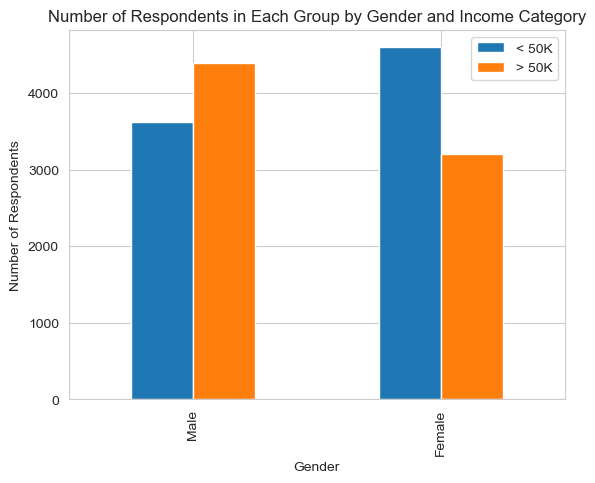

In [191]:
import seaborn as sns
import matplotlib.pyplot as plt

gender_labels = {1: "Male", 2: "Female"}

gb = df.groupby(["group"]).size()
print(f"# of males: {gb[1]}")
print(f"# of females: {gb[2]}")

# Count the number of people in each group based on gender and income category
gb1 = df.groupby(["group", "label"]).size().unstack()

percentages = df.groupby(['group'])['label'].mean()
male_percent = percentages[1]
female_percent = percentages[2]

print(f"\n% of males >50k/year: {male_percent.round(4)}")
print(f"% of femmales >50k/year: {female_percent.round(4)}")

# Plot the bar chart using Seaborn
sns.set_style("whitegrid")
ax = gb1.plot(kind="bar")

# Set labels and title
ax.set_xlabel("Gender")
ax.set_ylabel("Number of Respondents")
ax.set_title("Number of Respondents in Each Group by Gender and Income Category")

# Set custom tick labels for gender
ax.set_xticklabels(["Male", "Female"])

# Set legend
ax.legend(["< 50K", "> 50K"])

# Show the plot
plt.show()

These numbers and chart show a clear discrepancy between incomes of men and women. This may lead to allocative bias in certain implementations of this classification task, something I will talk about later in the blog post. 

Although I will be auditing for gender bias, it is important to look at various groups when assesing the data. Therefore, I will take a dive into the intersectional groupings of this data by looking at both race and gender. First, I will look at the number of people in each group by income and race.

*I will note that I combined the following least represented racial categories into one group called "other" in order to better visualise the data:*

- *American Indian alone*
- *Alaska Native alone*
- *American Indian and Alaska Native tribes specified, or American Indian or Alaska Native, not specified and no other race*
- *Native Hawaiian and Other Pacific Islander alone*
- *Some Other Race alone*
- *Two or More Races*

*I did this in order to simplify visualisation. I understand the importance of including these groups as seperate in the data, and ackgnowledge there could be nuances lost by grouping them together. I thought this choice would make it easier for the reader to understand the data.*

*Furthermore this data does not make the distinction between hispanic and non-hispanic respondents of each racial category. This could also lead to lost nuance when analyzing the data*

label        False  True 
group Race               
1     Aisan    147    213
      Black    370    165
      Other    356    118
      White   2750   3899
2     Aisan    197    161
      Black    505    207
      Other    374     89
      White   3524   2753


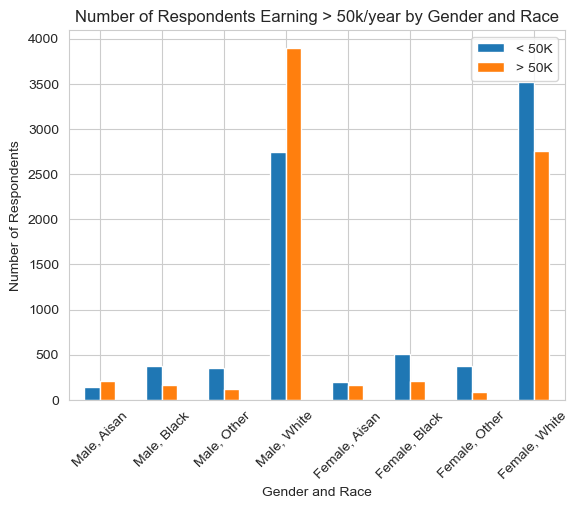

In [192]:
race_labels = {
    1: "White",
    2: "Black",
    6: "Aisan",
    **dict.fromkeys([3, 4, 5, 7, 8, 9], "Other"),
}

df["Race"] = df["RAC1P"].map(race_labels)

group_counts = df.groupby(["group", "Race", "label"]).size().unstack().fillna(0)

print(group_counts)

# Plot the bar chart using Seaborn
sns.set_style("whitegrid")
ax = group_counts.plot(kind="bar")

# Set labels and title
ax.set_xlabel("Gender and Race")
ax.set_ylabel("Number of Respondents")
ax.set_title("Number of Respondents Earning > 50k/year by Gender and Race")

# Set custom tick labels for gender and race
ax.set_xticklabels([(gender_labels[x[0]] + ', ' + x[1]) for x in group_counts.index], rotation=45)

# Set legend
ax.legend(["< 50K", "> 50K"])

# Show the plot
plt.show()

This graph clearly shows that there are is low representation of minority races in the dataset. This could definately lead to a decreasing classification accuracy for minority groups. We can also see a discrepency issue in incomes between white and asian respondents and respondents in the other groups. This becomes even more clear in the next graph:

Race      Aisan     Black     Other     White
group                                        
1      0.591667  0.308411  0.248945  0.586404
2      0.449721  0.290730  0.192225  0.438585


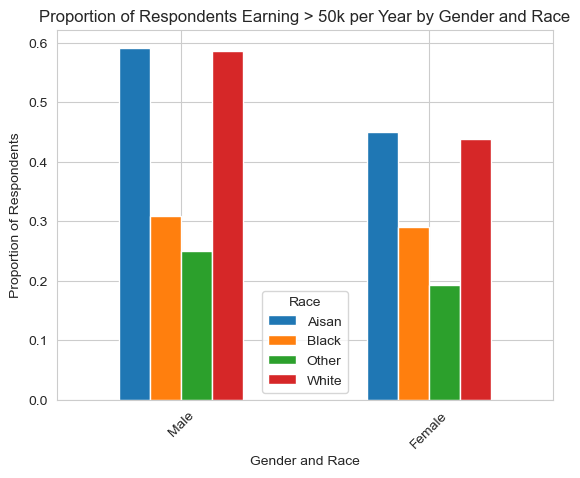

In [193]:
# Find percentage people in each gender and race group and check the percentage earning > 50k/year
gb_race = df.groupby(["group", "Race"])["label"].mean().unstack()

print(gb_race)

# Plot the bar chart using Seaborn
sns.set_style("whitegrid")
ax = gb_race.plot(kind="bar")

# Set labels and title
ax.set_xlabel("Gender and Race")
ax.set_ylabel("Proportion of Respondents")
ax.set_title("Proportion of Respondents Earning > 50k per Year by Gender and Race")

# Set custom tick labels for gender and race
ax.set_xticklabels(["Male", "Female"], rotation=45)

# Show the plot
plt.show()

This graph shows the percentage of people in each group that earn above 50k/year. As we can see there is a huge descrepancy between asian and white respondents and black respondents. Because we are training on racial data, I think it is important to note that such an algorithm could be exptremely problematic because race is being directly used as a factor to predict income.

# Training Model

Now that my data is prepared, its time to train the model! I will be using `sklearn`'s logistic regression model.

In [194]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X_train, y_train)

y_hat = model.predict(X_test)

acc = (y_hat == y_test).mean()
cm = confusion_matrix(y_test, y_hat)

print(f"Overall accuracy = {acc.round(4)}\n")
print(f"Confusion matrix =\n", cm)

TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]

PPV = TP/(FP+TP)
FPR = FP/(FP+TN)
FNR = FN/(FN+TP)

print(f"\nPPV = {PPV.round(4)}")
print(f"FPR = {FPR.round(4)}")
print(f"FNR = {FNR.round(4)}")

Overall accuracy = 0.7693

Confusion matrix =
 [[1626  473]
 [ 440 1418]]

PPV = 0.7499
FPR = 0.2253
FNR = 0.2368


Above we see that the accuracy of the of the model was around 77%. From the classification report we see that the precision (also known as positive predictive value) is 0.75. Furthermore, the false positve rate is 0.23 and the false negative rate is 0.24. This model does a pretty good job at predicting income categories based on demographic factors, excluding gender.

# Auditing for Bias

Now, I can test the acuraccy for male and female to see if there are any discrepencies in accuracy, PPV or false negative and positive rates.

In [195]:
acc_male = (y_hat == y_test)[group_test == 1].mean()
acc_fem = (y_hat == y_test)[group_test == 2].mean()
y_test_male, y_hat_male = y_test[group_test == 1], y_hat[group_test == 1]
y_test_fem, y_hat_fem = y_test[group_test == 2], y_hat[group_test == 2]

cm_m = confusion_matrix(y_test_male, y_hat_male)
print(f"Male accuracy = {acc_male.round(8)}\n")
print(f"Confusion matrix =\n", cm_m)

TN_m = cm_m[0][0]
FP_m = cm_m[0][1]
FN_m = cm_m[1][0]
TP_m = cm_m[1][1]

PPV_m = TP_m/(FP_m+TP_m)
FPR_m = FP_m/(FP_m+TN_m)
FNR_m = FN_m/(FN_m+TP_m)

print(f"\nPPV = {PPV_m.round(4)}")
print(f"FPR = {FPR_m.round(4)}")
print(f"FNR = {FNR_m.round(4)}")

cm_f = confusion_matrix(y_test_fem, y_hat_fem)
print(f"\nFemale accuracy = {acc_fem.round(8)}\n")
print(f"Confusion matrix =\n", cm_f)

TN_f = cm_f[0][0]
FP_f = cm_f[0][1]
FN_f = cm_f[1][0]
TP_f = cm_f[1][1]

PPV_f = TP_f/(FP_f+TP_f)
FPR_f = FP_f/(FP_f+TN_f)
FNR_f = FN_f/(FN_f+TP_f)

print(f"\nPPV = {PPV_f.round(4)}")
print(f"FPR = {FPR_f.round(4)}")
print(f"FNR = {FNR_f.round(4)}")

Male accuracy = 0.78973346

Confusion matrix =
 [[735 166]
 [260 865]]

PPV = 0.839
FPR = 0.1842
FNR = 0.2311

Female accuracy = 0.74779907

Confusion matrix =
 [[891 307]
 [180 553]]

PPV = 0.643
FPR = 0.2563
FNR = 0.2456


As we can see, the acuracy for this model is significantly higher when predicting income for males than females. On top of that, the positive predictive value (PPV or precision) is way higher for males than females. Furthuremore, the false positive rate is significantly higher for women than for men. The false negative rate is also higher for females, but to a lesser extent.

## Bias measures discussion

#### Error Rate Balance

From above we see that there is a large discrepancy between the false positive error rates between males and femailes. That means that this model does not pass the error rate balance test. 

#### Calibration

Below, I calculated and plotted the fraction of respondents whose predicted income was over 50k/year that actually had an income over 50k/year:

[[0.26130653 0.16806723]
 [0.83899127 0.64302326]]


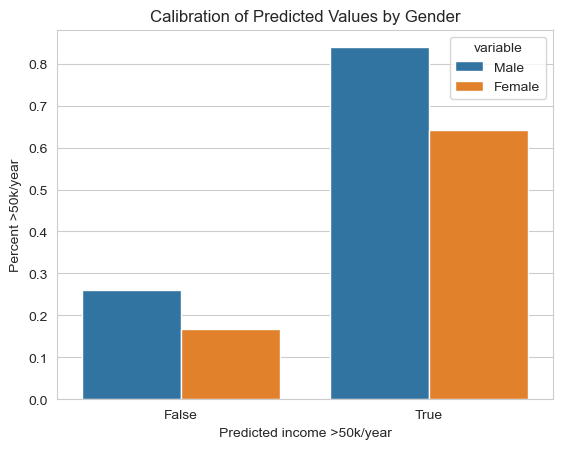

In [196]:
df_male = pd.DataFrame(np.array([y_test_male, y_hat_male]).T, columns=["income", "income_pred"])
df_fem = pd.DataFrame(np.array([y_test_fem, y_hat_fem]).T, columns=["income", "income_pred"])

gb_m = df_male.groupby(["income_pred"])["income"].mean()
gb_f = df_fem.groupby(["income_pred"])["income"].mean()

calibration = [[gb_m[0], gb_f[0]],
               [gb_m[1], gb_f[1]]]

print(np.matrix(calibration))

df_calib = pd.DataFrame(calibration, columns=['Male', 'Female'], index=['False', 'True'])
df_calib = df_calib.reset_index().melt('index')

# Plot the bar chart using Seaborn
sns.set_style("whitegrid")
ax = sns.barplot(x='index', y='value', hue='variable', data=df_calib)

# Set labels and title
ax.set_xlabel('Predicted income >50k/year')
ax.set_ylabel('Percent >50k/year')
ax.set_title('Calibration of Predicted Values by Gender')

# Show the plot
plt.show()

As we can see our model is not that well calibrated. The odds that a female who is predicted to have an income above 50k/year actualy has that income is around 64%, whereas for males that number is 84%. Interestingly, this calibration shows somewhat of a bias towards females because women who are predicted to have higher incomes are more likely than men to actually earn less than 50k/year.

#### Statistical Parity

Below I calculated the percentage of each gender group that was predicted to have an income over 50k/year.

In [208]:
print(f"Male acceptance rate = {(y_hat_male.sum()/len(y_test_male)).round(4)}")
print(f"Feale acceptance rate = {(y_hat_fem.sum()/len(y_test_fem)).round(4)}")

Male acceptance rate = 0.5089
Feale acceptance rate = 0.4454


As we can see, there is also a significant discrepancy for statistical parity that shows bias against women. The algorithm predicts more women to fall into the lower income bracket.

# Concluding Discussion

**What groups of people could stand to benefit from a system that is able to predict the label you predicted, such as income or employment status? For example, what kinds of companies might want to buy your model for commercial use?**

There are multiple ways that a model that predicts income based on demographic feature could be used. Here are two ideas I had:

1. Companies could use income prediction algorithms to tailor their marketing strategies and campaigns. By understanding the income levels of their target audience, businesses can customize their offerings, pricing, and promotional activities to better suit the preferences and purchasing power of different income groups.

2. Human resources departments could use income prediction models when assessing job applicants. Through such algorithm, employers can gain insights into a candidate's potential salary expectations. This information could help inform job offers.

3. Governments and policymakers could utilize income prediction algorithms to plan and evaluate social policies. For instance, by estimating income levels for a specific population, policymakers can identify groups that may require targeted support.

**Based on your bias audit, what could be the impact of deploying your model for large-scale prediction in commercial or governmental settings?**

1. This case would be the least problematic in my opinion. Nevertheless, the bias in my algorithm could lead companies marketing more "incorrect" products to women than men.

2. This case could prove detrimental. Bias in an algorithm that predicts income in the case of hiring could mean that women would be offered a lower salary upon accepting a job. My algorithm did not pass the statistical parity test, meaning that it more often places women in the lower income bracket. Nevertheless, in the calibration section, women were predicted to have higher incomes were more likely than men to be in the lower income bracket. I would argue that statistical parity matters more in this case because the effect of a negative prediction is worse than the effect of a positive prediction.

3. This could also prove detrimental. If a government wrongly predicts the amount of need for a certain individual or comunity, they may be unable to povide the proper services. In this case the low acceptace rate for women in the statistical parity test coul actually mean that many women wouldn't get the services they need because their income is being predicted too high.

**Based on your bias audit, do you feel that your model displays problematic bias? What kind (calibration, error rate, etc)?**

All of the bias audits were unsucessful and therefore I would conclude that this algorithm is demonstrates a highly problematic amount of bias and probably should not be utilized. It showed bias in calibration, error rate and statistical parity.

**Beyond bias, are there other potential problems associated with deploying your model that make you uncomfortable? How would you propose addressing some of these problems?**

Yes, as I said before, this model uses race as a predictor. I think this is highly problematic. There may be cases where race could be used as a predictor, perhaps for an algorithm that predicts certain medical conditions that may vary in prevelance between different races.

On top of that, I think that this algorithm would just further the salary discrepancies we see between men and women today. I think that that is one of the biggest issues with predictive algorithms like these. They use data that shows trends based on a history of discrimination and opression and deppen those trends by predicting outcomes based on demographics without ackgnowledging the myriad of historical factors that created those outcomes.